In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, validate_model, infer_model
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
import glob

DATA_PATH = '../processed_data/'

data = dict()
labels = dict()
for file in glob.glob(DATA_PATH + 'S*_P300_PZ.csv'):
    subj = file.split('/')[-1][:5]
    mat_data = np.loadtxt(file, delimiter=',')
    data[subj] = mat_data[:, 1:]
    labels[subj] = mat_data[:, 0]
    positive_samples = data[subj][labels[subj] == 1]
    positive_labels = labels[subj][labels[subj] == 1]
    temp_data = [data[subj]]
    temp_labels = [labels[subj]]
    for i in range(15):
        temp_data.append(positive_samples)
        temp_labels.append(positive_labels)
    data[subj] = np.vstack(temp_data)
    labels[subj] = np.hstack(temp_labels)

In [6]:
min_len = min(arr.shape[0] for arr in labels.values())

for subj in data.keys():
    permutation = torch.randperm(min_len)
    data[subj] = torch.tensor(data[subj][:min_len]).unsqueeze(1).float()[permutation]
    labels[subj] = torch.tensor(labels[subj].squeeze()[:min_len])[permutation]

In [7]:
all_train_data = []
all_train_labels = []
all_val_data = []
all_val_labels = []

for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )
    all_train_data.append(train_data)
    all_train_labels.append(train_labels)
    all_val_data.append(val_data)
    all_val_labels.append(val_labels)

train_dataset = CNNMatrixDataset(tensors=(torch.cat(all_train_data, 0), torch.cat(all_train_labels)), with_target=True, transform=None)
val_dataset = CNNMatrixDataset(tensors=(torch.cat(all_val_data, 0), torch.cat(all_val_labels)), with_target=True, transform=None)
all_dataloader = dict()
all_dataloader['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
all_dataloader['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)

/home/leonid/Projects/multi_eeg/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Training complete in 5m 28s
accuracy:  0.5998459958932238
f1-score:  0.601054301653104
S2001 accuracy CI: [0.593, 0.607]


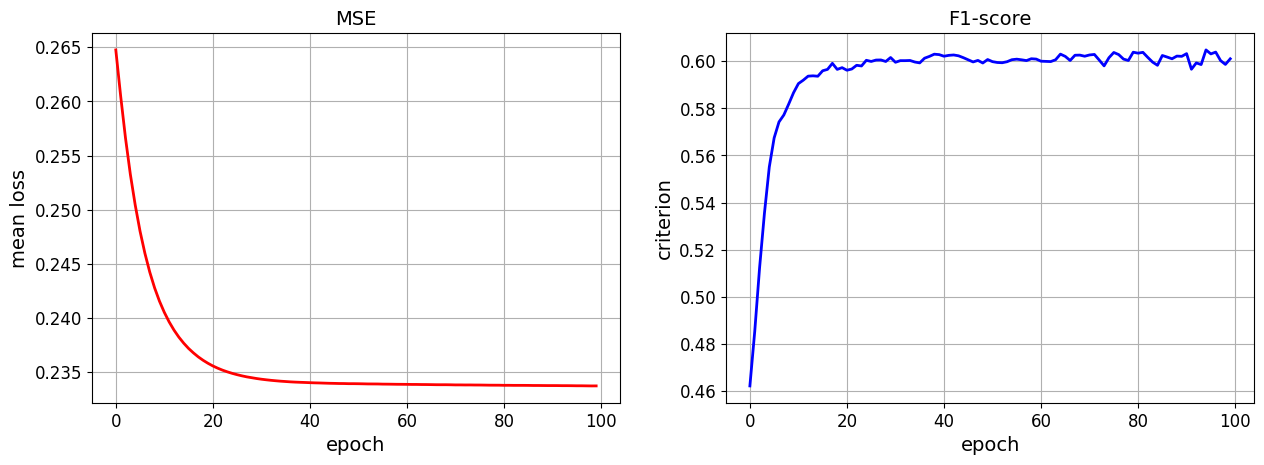

In [8]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-5,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

common_model = BaseCNN(250, 1)
loss, acc, total_time = train_model(common_model, all_dataloader, criterion, learning_params, device=my_device)
print('accuracy: ', acc['Accuracy'][-1])
print('f1-score: ', acc['F1-score'][-1])
print(f'{subj} accuracy CI: [{round(acc["Min Accuracy"][-1], 3)}, {round(acc["Max Accuracy"][-1], 3)}]')
show_progress(loss, acc, 'MSE', 'F1-score')

In [9]:
dataloaders = dict()
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )
    train_dataset = CNNMatrixDataset(tensors=(train_data, train_labels), with_target=True, transform=None)
    val_dataset = CNNMatrixDataset(tensors=(val_data, val_labels), with_target=True, transform=None)
    temp_dataloaders = dict()
    temp_dataloaders['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    temp_dataloaders['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)
    dataloaders[subj] = temp_dataloaders

Common model metrics:
S1901 accuracy:  tensor(0.7428, dtype=torch.float64)
S1901 f1-score:  tensor(0.7750, device='cuda:0', dtype=torch.float64)
S1901 accuracy CI: [0.723, 0.762]
Training complete in 2m 47s

Specific model metrics:
S1901 accuracy:  0.8162217659137577
S1901 f1-score:  0.813735691987513
S1901 accuracy CI: [0.799, 0.833]


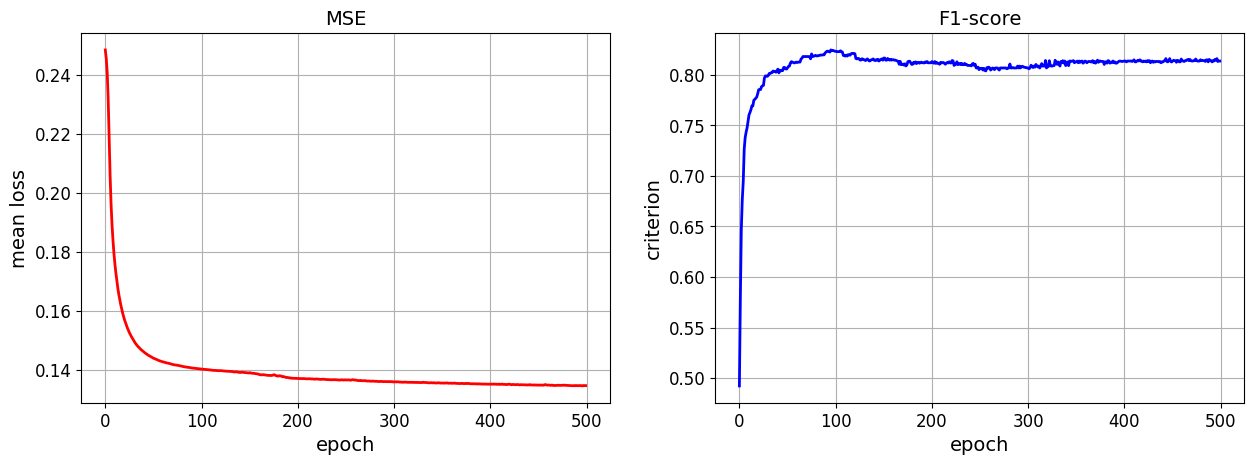

Common model metrics:
S1601 accuracy:  tensor(0.6437, dtype=torch.float64)
S1601 f1-score:  tensor(0.6651, device='cuda:0', dtype=torch.float64)
S1601 accuracy CI: [0.622, 0.665]
Training complete in 2m 46s

Specific model metrics:
S1601 accuracy:  0.7109856262833676
S1601 f1-score:  0.7302347867752755
S1601 accuracy CI: [0.691, 0.731]


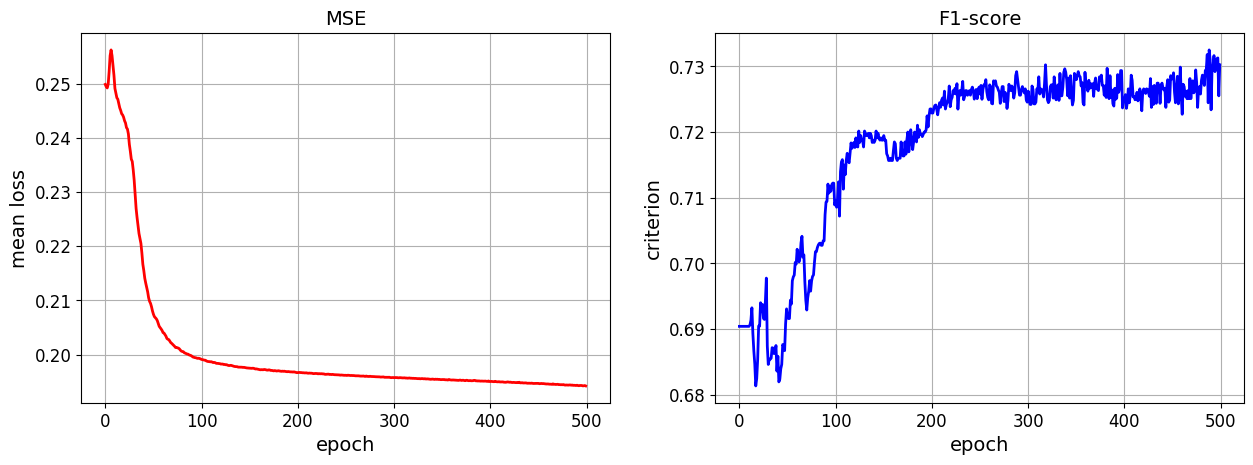

Common model metrics:
S0701 accuracy:  tensor(0.5811, dtype=torch.float64)
S0701 f1-score:  tensor(0.5683, device='cuda:0', dtype=torch.float64)
S0701 accuracy CI: [0.559, 0.603]
Training complete in 2m 44s

Specific model metrics:
S0701 accuracy:  0.6078028747433265
S0701 f1-score:  0.6262230919765166
S0701 accuracy CI: [0.586, 0.629]


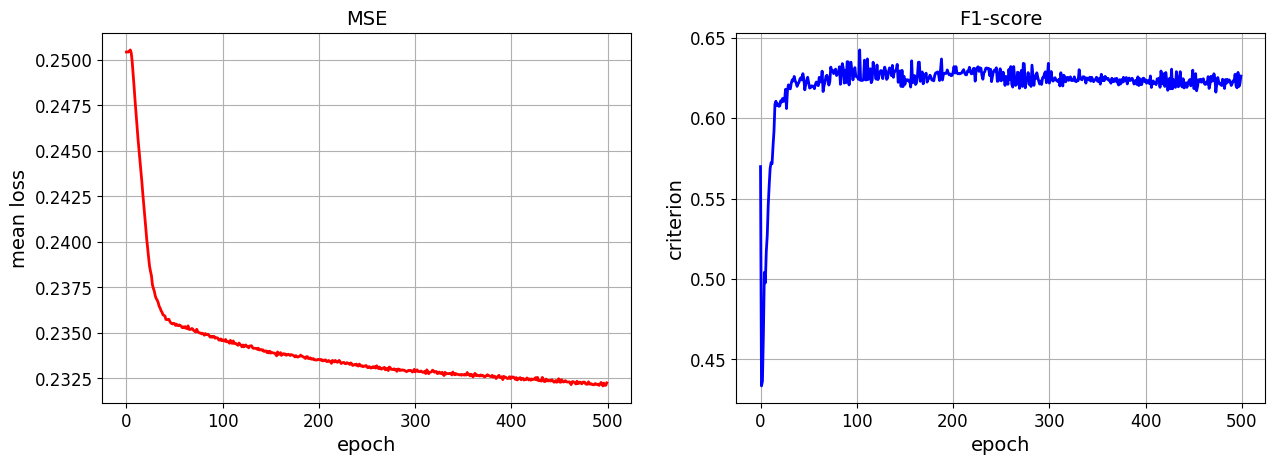

Common model metrics:
S1701 accuracy:  tensor(0.5939, dtype=torch.float64)
S1701 f1-score:  tensor(0.5826, device='cuda:0', dtype=torch.float64)
S1701 accuracy CI: [0.572, 0.616]
Training complete in 2m 48s

Specific model metrics:
S1701 accuracy:  0.6642710472279261
S1701 f1-score:  0.6736526946107785
S1701 accuracy CI: [0.643, 0.685]


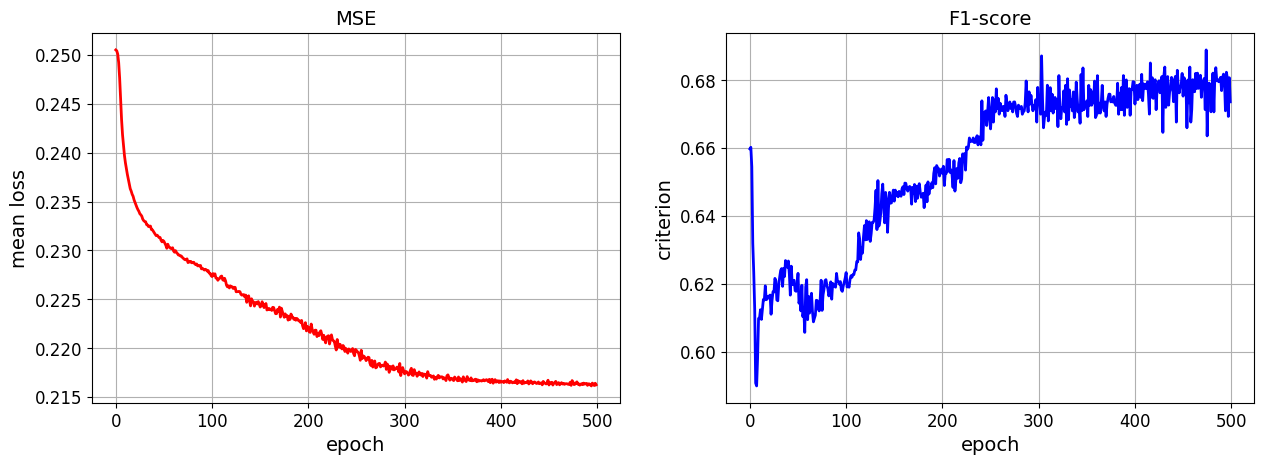

Common model metrics:
S0601 accuracy:  tensor(0.4738, dtype=torch.float64)
S0601 f1-score:  tensor(0.4044, device='cuda:0', dtype=torch.float64)
S0601 accuracy CI: [0.452, 0.496]
Training complete in 2m 47s

Specific model metrics:
S0601 accuracy:  0.6427104722792608
S0601 f1-score:  0.6682554814108675
S0601 accuracy CI: [0.621, 0.664]


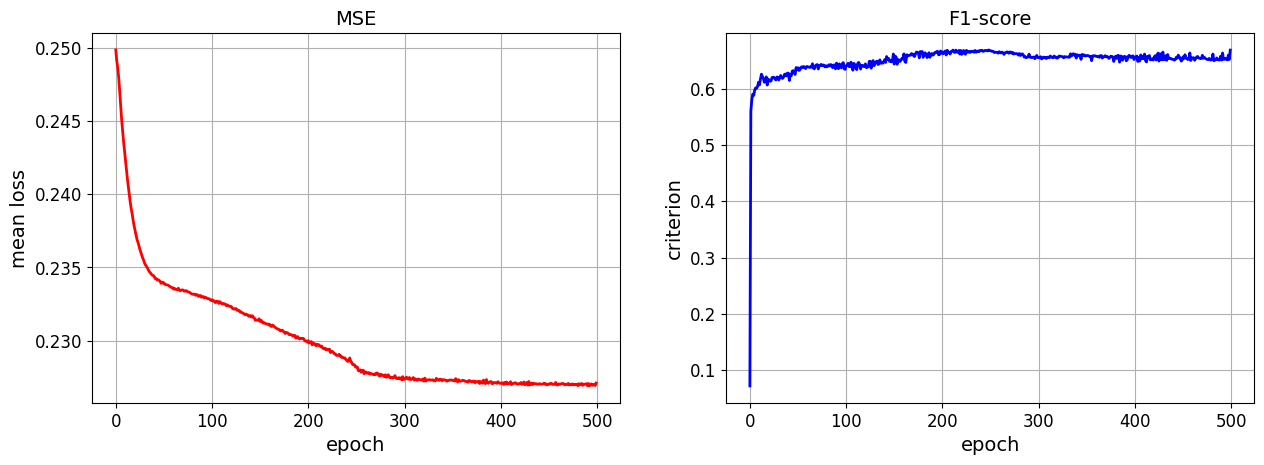

Common model metrics:
S1401 accuracy:  tensor(0.6258, dtype=torch.float64)
S1401 f1-score:  tensor(0.6283, device='cuda:0', dtype=torch.float64)
S1401 accuracy CI: [0.604, 0.647]
Training complete in 2m 46s

Specific model metrics:
S1401 accuracy:  0.6930184804928131
S1401 f1-score:  0.7071498530852106
S1401 accuracy CI: [0.673, 0.714]


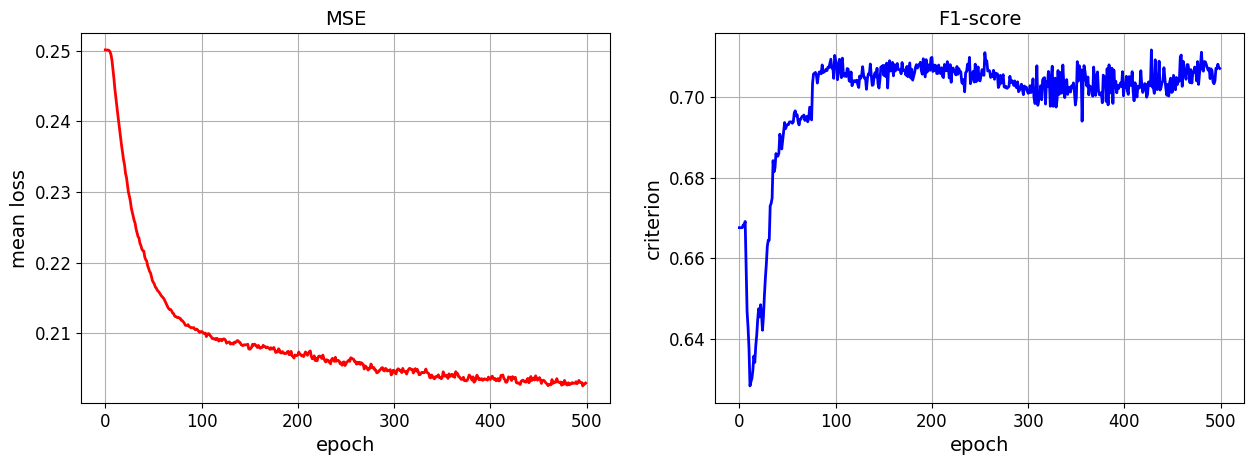

Common model metrics:
S1201 accuracy:  tensor(0.6099, dtype=torch.float64)
S1201 f1-score:  tensor(0.6181, device='cuda:0', dtype=torch.float64)
S1201 accuracy CI: [0.588, 0.632]
Training complete in 2m 44s

Specific model metrics:
S1201 accuracy:  0.6791581108829569
S1201 f1-score:  0.6970431410567136
S1201 accuracy CI: [0.658, 0.7]


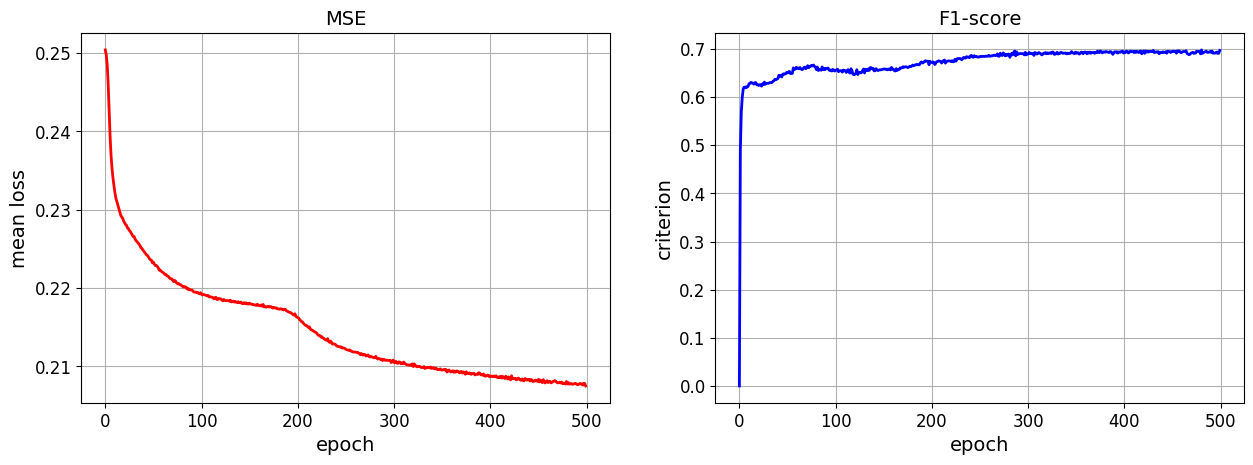

Common model metrics:
S1801 accuracy:  tensor(0.5678, dtype=torch.float64)
S1801 f1-score:  tensor(0.5296, device='cuda:0', dtype=torch.float64)
S1801 accuracy CI: [0.546, 0.59]
Training complete in 2m 43s

Specific model metrics:
S1801 accuracy:  0.6473305954825462
S1801 f1-score:  0.6559839759639459
S1801 accuracy CI: [0.626, 0.669]


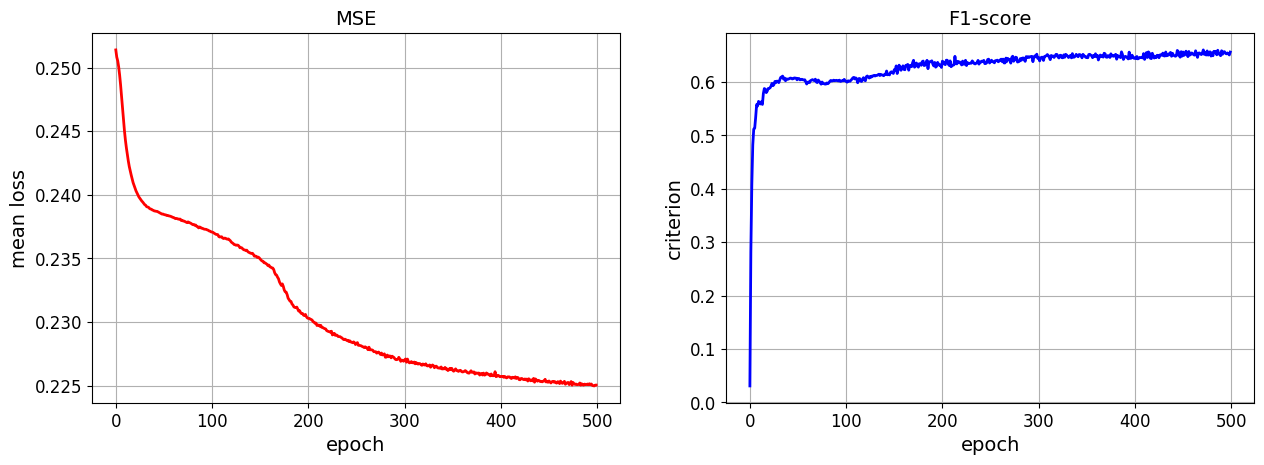

Common model metrics:
S0201 accuracy:  tensor(0.6309, dtype=torch.float64)
S0201 f1-score:  tensor(0.6501, device='cuda:0', dtype=torch.float64)
S0201 accuracy CI: [0.609, 0.652]
Training complete in 2m 46s

Specific model metrics:
S0201 accuracy:  0.6652977412731006
S0201 f1-score:  0.6844143272023233
S0201 accuracy CI: [0.644, 0.686]


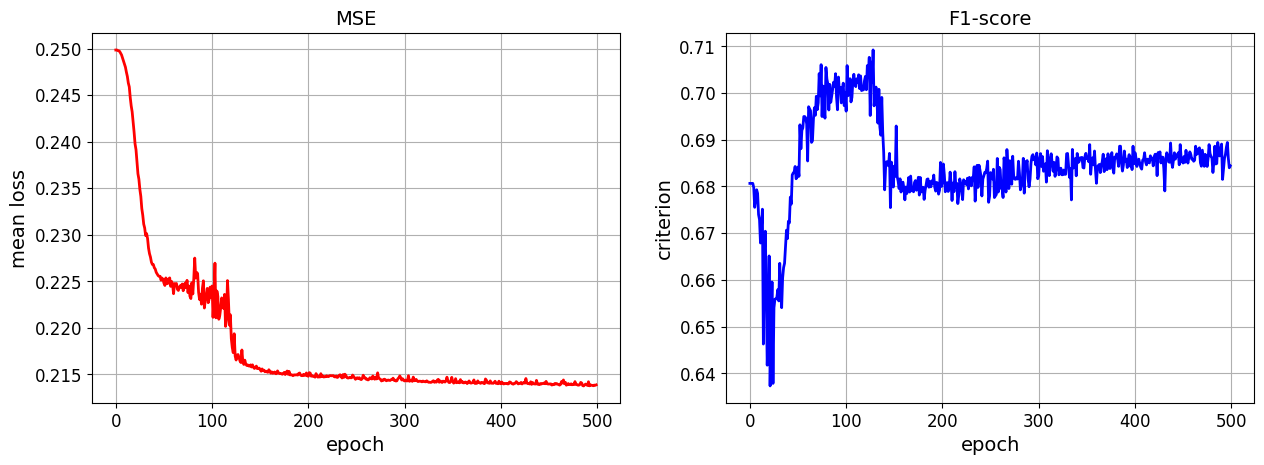

Common model metrics:
S2001 accuracy:  tensor(0.5287, dtype=torch.float64)
S2001 f1-score:  tensor(0.5263, device='cuda:0', dtype=torch.float64)
S2001 accuracy CI: [0.507, 0.551]
Training complete in 2m 46s

Specific model metrics:
S2001 accuracy:  0.6006160164271047
S2001 f1-score:  0.6167487684729064
S2001 accuracy CI: [0.579, 0.622]


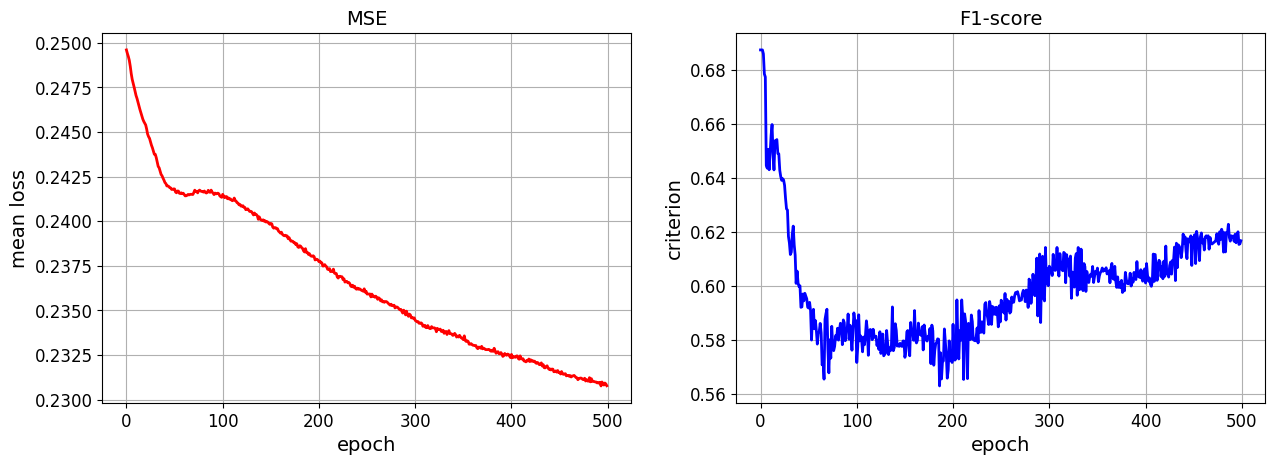

In [10]:
criterion = nn.MSELoss()

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

result_sep = dict()
single_models = dict()
for subj, dataloader in dataloaders.items():
    common_acc = validate_model(common_model, dataloader['val'], device=my_device)
    print('Common model metrics:')
    print(f'{subj} accuracy: ', common_acc['Accuracy'])
    print(f'{subj} f1-score: ', common_acc['F1-score'])
    print(f'{subj} accuracy CI: [{round(common_acc["Min Accuracy"], 3)}, {round(common_acc["Max Accuracy"], 3)}]')
    single_models[subj] = BaseCNN(250, 1)
    loss, acc, total_time = train_model(single_models[subj], dataloader, criterion, learning_params, device=my_device)
    print()
    print('Specific model metrics:')
    print(f'{subj} accuracy: ', acc['Accuracy'][-1])
    print(f'{subj} f1-score: ', acc['F1-score'][-1])
    print(f'{subj} accuracy CI: [{round(acc["Min Accuracy"][-1], 3)}, {round(acc["Max Accuracy"][-1], 3)}]')
    show_progress(loss, acc, 'MSE', 'F1-score')
    result_sep[subj] = {'accuracy': acc['Accuracy'][-1], 
                        'f1-score': acc['F1-score'][-1],
                        'size': len(dataloader['val'].dataset),
                        'lower_ci': acc['Min Accuracy'][-1],
                        'upper_ci': acc['Max Accuracy'][-1]}

In [11]:
sum([value['accuracy'] * value['size'] for value in result_sep.values()]) / sum([value['size'] for value in result_sep.values()])

0.672741273100616

In [12]:
min_pos_train, min_neg_train = 10000, 10000
min_pos_val, min_neg_val = 10000, 10000
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )

    min_pos_train = min(min_pos_train, (train_labels == 1).sum())
    min_neg_train = min(min_neg_train, (train_labels == 0).sum())
    min_pos_val = min(min_pos_val, (val_labels == 1).sum())
    min_neg_val = min(min_neg_val, (val_labels == 0).sum())

result_pos_train, result_neg_train = [], []
result_pos_val, result_neg_val = [], []
for subj in data.keys():
    train_data, val_data, train_labels, val_labels = train_test_split(
        data[subj], 
        labels[subj], 
        test_size=0.15,
        shuffle=False
    )

    result_pos_train.append(train_data[train_labels == 1][:min_pos_train][torch.randperm(min_pos_train)])
    result_neg_train.append(train_data[train_labels == 0][:min_neg_train][torch.randperm(min_neg_train)])
    result_pos_val.append(train_data[train_labels == 1][:min_pos_val][torch.randperm(min_pos_val)])
    result_neg_val.append(train_data[train_labels == 0][:min_neg_val][torch.randperm(min_neg_val)])

In [13]:
train_data = torch.cat([torch.cat(result_pos_train, 1), torch.cat(result_neg_train, 1)], 0)
val_data = torch.cat([torch.cat(result_pos_val, 1), torch.cat(result_neg_val, 1)], 0)
train_labels = torch.cat([torch.ones(min_pos_train, dtype=torch.float64), torch.zeros(min_neg_train, dtype=torch.float64)])
val_labels = torch.cat([torch.ones(min_pos_val, dtype=torch.float64), torch.zeros(min_neg_val, dtype=torch.float64)])

train_dataset = CNNMatrixDataset(tensors=(train_data, train_labels), with_target=True, transform=None)
val_dataset = CNNMatrixDataset(tensors=(val_data, val_labels), with_target=True, transform=None)
all_dataloader = dict()
all_dataloader['train'] = DataLoader(train_dataset, batch_size=1024, shuffle=True)
all_dataloader['val'] = DataLoader(val_dataset, batch_size=1024, shuffle=True)

Training complete in 3m 0s
accuracy:  0.8578274760383388
f1-score:  0.8585055643879171


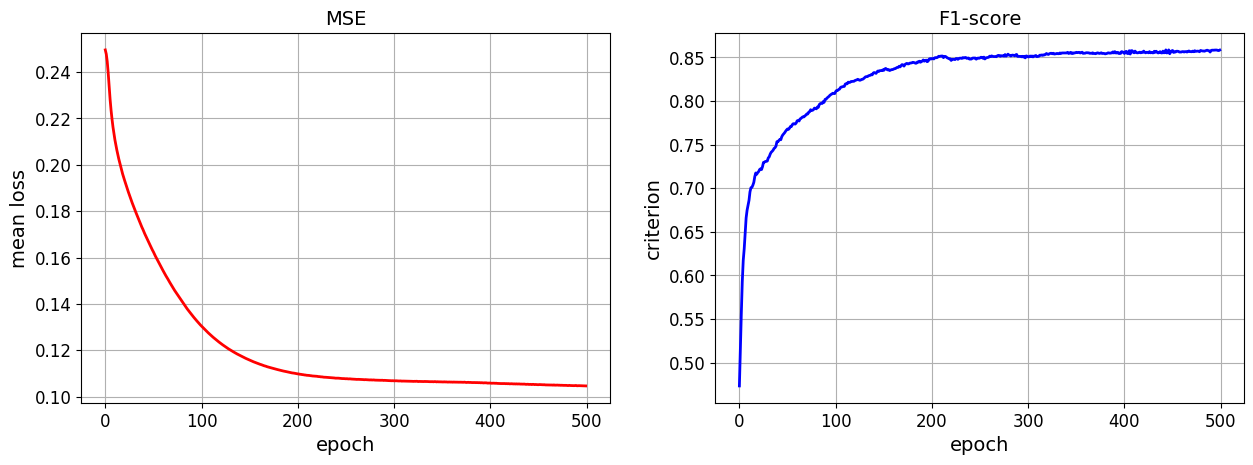

In [14]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)
my_device = torch.device('cuda:0')

mc_model = BaseCNN(250, 10)
loss, acc, total_time = train_model(mc_model, all_dataloader, criterion, learning_params, device=my_device)
print('accuracy: ', acc['Accuracy'][-1])
print('f1-score: ', acc['F1-score'][-1])
show_progress(loss, acc, 'MSE', 'F1-score')

In [15]:
val_all_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

mc_preds = infer_model(mc_model, val_all_dataloader, device=my_device)[:, 1]

single_model_preds = []
common_model_preds = []
for i, subj in enumerate(data.keys()):
    single_model_preds.append(infer_model(single_models[subj], val_all_dataloader, channel=i, device=my_device)[:, 1])
    common_model_preds.append(infer_model(common_model, val_all_dataloader, channel=i, device=my_device)[:, 1])

In [16]:
labels = torch.cat([data[1] for data in val_all_dataloader])[:, 1]

In [17]:
soft_single = (torch.stack(single_model_preds).T.mean(dim=1) > 0.5).float()
hard_single = ((torch.stack(single_model_preds).T > 0.5).sum(dim=1) > 5).float()

soft_common = (torch.stack(common_model_preds).T.mean(dim=1) > 0.5).float()
hard_common = ((torch.stack(common_model_preds).T > 0.5).sum(dim=1) > 5).float()

single_model = []
for preds in single_model_preds:
    single_model.append((preds > 0.5).float())

mc = (mc_preds > 0.5).float()

In [18]:
all_predictions = [soft_single, hard_single, mc, soft_common, hard_common]
predictions_names = ['different models [soft voting]',
                     'different models [hard voting]',
                     'multi channel model           ',
                     'one common model [soft voting]',
                     'one common model [hard voting]']

print('model type                    CI lower CI upper')
for preds, title in zip(all_predictions, predictions_names):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    print(title, round(min_acc, 3), round(max_acc, 3), sep='\t')

for preds, subj in zip(single_model, data.keys()):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    print(f'solo {subj} model performance', round(min_acc, 3), round(max_acc, 3), sep='\t')

model type                    CI lower CI upper
different models [soft voting]	0.927	0.949
different models [hard voting]	0.872	0.9
multi channel model           	0.842	0.874
one common model [soft voting]	0.781	0.817
one common model [hard voting]	0.695	0.736
solo S1901 model performance	0.795	0.831
solo S1601 model performance	0.699	0.739
solo S0701 model performance	0.6	0.644
solo S1701 model performance	0.639	0.682
solo S0601 model performance	0.644	0.687
solo S1401 model performance	0.673	0.715
solo S1201 model performance	0.685	0.726
solo S1801 model performance	0.637	0.68
solo S0201 model performance	0.652	0.695
solo S2001 model performance	0.591	0.635


* Лучше всего работает усреднение разных моделей

* Общая модель на 10 каналов стат значимо хуже усреднения одиночных

* Использование же общей модели для каждого канала работает хуже, чем лучшая из одиночных моделей

In [31]:
all_predictions = [soft_single, hard_single, mc, soft_common, hard_common]
predictions_names = ['different models [soft voting]',
                     'different models [hard voting]',
                     'multi channel model           ',
                     'one common model [soft voting]',
                     'one common model [hard voting]']

print('model type                    CI lower CI upper TP      FN      FP      TN')
for preds, title in zip(all_predictions, predictions_names):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    TP = int(sum(preds[labels == 1] == 1))
    FN = int(sum(preds[labels == 1] == 0))
    FP = int(sum(preds[labels == 0] == 1))
    TN = int(sum(preds[labels == 0] == 0))
    print(title, round(min_acc, 3), round(max_acc, 3), TP, FN, FP, TN, sep='\t')

for preds, subj in zip(single_model, data.keys()):
    min_acc, max_acc = proportion_confint(sum(preds == labels), len(val_all_dataloader.dataset), 0.05)
    TP = int(sum(preds[labels == 1] == 1))
    FN = int(sum(preds[labels == 1] == 0))
    FP = int(sum(preds[labels == 0] == 1))
    TN = int(sum(preds[labels == 0] == 0))
    print(f'solo {subj} model performance', round(min_acc, 3), round(max_acc, 3), TP, FN, FP, TN, sep='\t')

model type                    CI lower CI upper TP      FN      FP      TN
different models [soft voting]	0.927	0.949	924	35	82	837
different models [hard voting]	0.872	0.9	819	140	74	845
multi channel model           	0.842	0.874	810	149	118	801
one common model [soft voting]	0.781	0.817	844	115	263	656
one common model [hard voting]	0.695	0.736	560	399	135	784
solo S1901 model performance	0.795	0.831	743	216	135	784
solo S1601 model performance	0.699	0.739	689	270	258	661
solo S0701 model performance	0.6	0.644	638	321	389	530
solo S1701 model performance	0.639	0.682	693	266	371	548
solo S0601 model performance	0.644	0.687	680	279	349	570
solo S1401 model performance	0.673	0.715	692	267	308	611
solo S1201 model performance	0.685	0.726	679	280	273	646
solo S1801 model performance	0.637	0.68	626	333	309	610
solo S0201 model performance	0.652	0.695	684	275	338	581
solo S2001 model performance	0.591	0.635	589	370	356	563
